In [1]:
!nvidia-smi

Fri Mar  7 03:50:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:41:00.0 Off |                    0 |
| N/A   25C    P0             57W /  500W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import os
import json
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

from transformers import (
    SwinModel,
    T5ForConditionalGeneration,
    T5Tokenizer,
)
from transformers.modeling_outputs import BaseModelOutput

###############################################
# Dataset
###############################################

class ImageCaptionDataset(Dataset):
    """
    Expects a JSONL file where each line is a JSON object with:
      - "image": filename of the image.
      - "suffix": the associated caption.
    """
    def __init__(self, jsonl_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = []
        with open(jsonl_file, 'r') as f:
            for line in f:
                record = json.loads(line)
                self.data.append(record)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        record = self.data[idx]
        image_name = record["image"]
        caption = record["suffix"]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, caption

###############################################
# Collate Function
###############################################

def collate_fn(batch, tokenizer, max_length=50):
    """
    Collates a batch of (image, caption) tuples.
    Tokenizes captions using the provided tokenizer and pads them.
    """
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    images = torch.stack(images, 0)
    # Tokenize and pad captions.
    captions_enc = tokenizer(
        captions, 
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors="pt"
    )
    # For T5, the labels (decoder targets) are the token ids.
    labels = captions_enc["input_ids"]
    return images, labels

###############################################
# Image Captioning Model: Swin + T5
###############################################

class ImageCaptioningModel(nn.Module):
    def __init__(self,
                 swin_model_name="microsoft/swin-base-patch4-window7-224",
                 t5_model_name="t5-base"):
        super().__init__()
        # Load the pretrained Swin Transformer.
        self.swin = SwinModel.from_pretrained(swin_model_name)
        # Load the pretrained T5 model.
        self.t5 = T5ForConditionalGeneration.from_pretrained(t5_model_name)
        # Project Swin's hidden size to T5's hidden dimension.
        self.img_proj = nn.Linear(self.swin.config.hidden_size, self.t5.config.d_model)
    
    def forward(self, images, labels=None):
        # Extract image features using Swin.
        swin_outputs = self.swin(images)
        # Use the last hidden state as visual features.
        img_feats = swin_outputs.last_hidden_state  # shape: (batch, seq_len, swin_hidden_size)
        # Project features to match T5's d_model.
        img_feats_proj = self.img_proj(img_feats)     # shape: (batch, seq_len, t5_hidden_size)
        # Wrap projected features as encoder outputs.
        encoder_outputs = BaseModelOutput(last_hidden_state=img_feats_proj)
        if labels is not None:
            # When labels are provided, T5 will compute the loss.
            outputs = self.t5(encoder_outputs=encoder_outputs, labels=labels)
        else:
            outputs = self.t5(encoder_outputs=encoder_outputs)
        return outputs

###############################################
# Validation Function
###############################################

def validate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_steps = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            total_steps += 1

    avg_loss = total_loss / total_steps if total_steps > 0 else 0
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss

###############################################
# Training and Validation Loop
###############################################

def train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs, save_path='swin-t5-model.pth'):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # Run validation after each epoch
        print(f"\nEpoch {epoch+1} completed. Running validation...")
        val_loss = validate(model, val_loader, device)
        print("-" * 50)
        
        generate_caption_for_random_image(model, val_img_dir, transform, tokenizer, device, max_length=516)
        
        # Save model if validation loss improves.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")

/cluster/home/ammaa/.conda/envs/ammars/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-10 16:35:22.651826: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 16:35:28.509861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 16:36:46.831346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import random
import matplotlib.pyplot as plt

def generate_caption_for_random_image(model, image_dir, transform, tokenizer, device, max_length=50):
    """
    Randomly selects an image from image_dir, generates a caption using the model,
    and displays the image with the generated caption.
    """
    # List all image files in the directory (supports jpg, jpeg, png)
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print("No image files found in directory.")
        return

    # Randomly choose an image.
    random_image = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image)
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image.
    input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension.

    # Generate caption.
    model.eval()
    with torch.no_grad():
        # Extract features using the Swin encoder.
        swin_outputs = model.swin(input_image)
        img_feats = swin_outputs.last_hidden_state  # shape: (1, seq_len, swin_hidden_size)
        # Project features to T5's hidden dimension.
        img_feats_proj = model.img_proj(img_feats)     # shape: (1, seq_len, t5_hidden_size)
        # Wrap the projected features as encoder outputs.
        encoder_outputs = BaseModelOutput(last_hidden_state=img_feats_proj)
        # Use T5's generate method. Adjust generation parameters as needed.
        generated_ids = model.t5.generate(
            encoder_outputs=encoder_outputs,
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )
        # Decode the generated ids to text.
        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Display the image and generated caption.
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

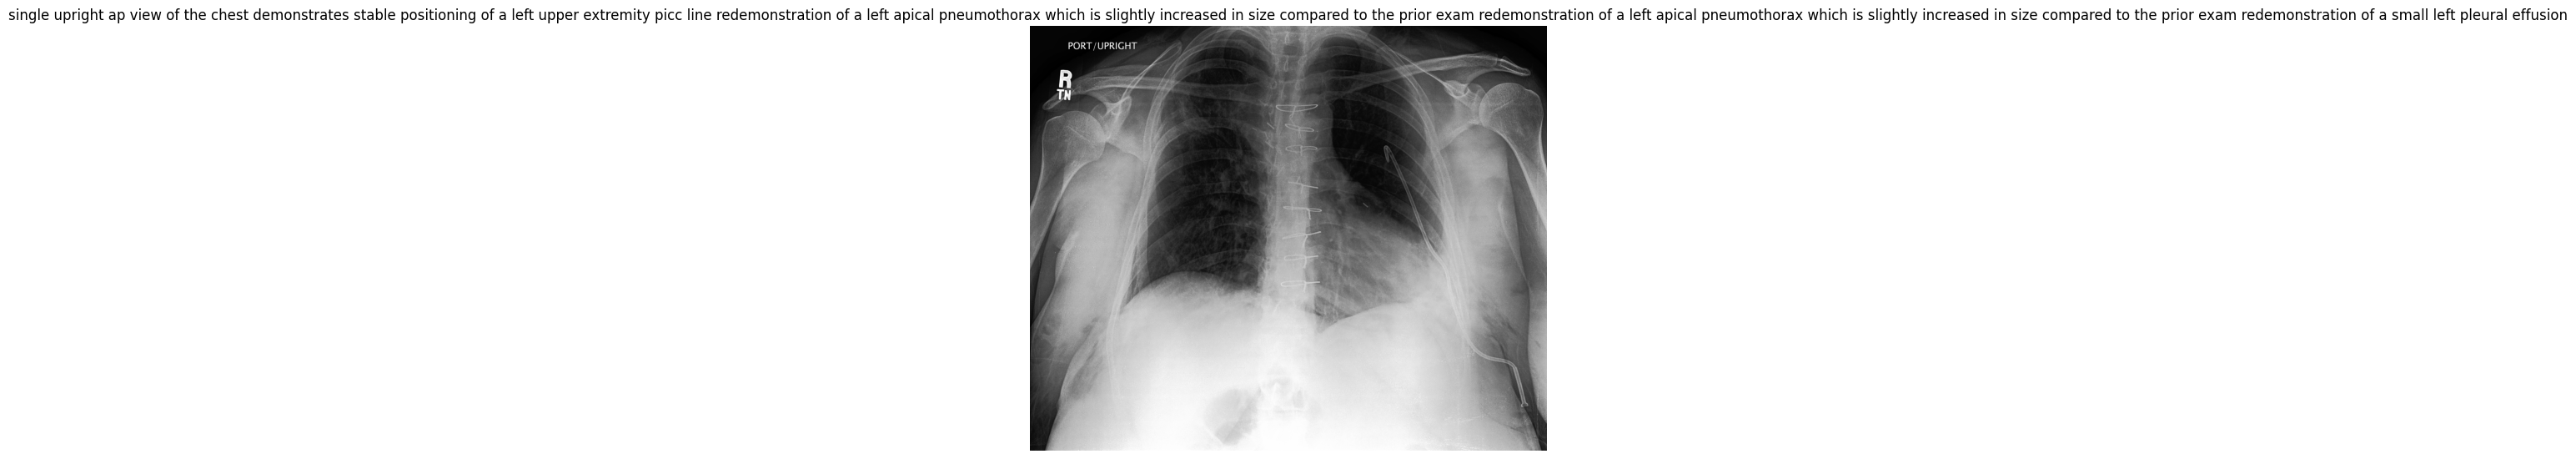

In [6]:
image_dir = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/test'
generate_caption_for_random_image(model, image_dir, transform, tokenizer, device, max_length=100)

In [ ]:
pip install sentencepiece

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Training Epoch 1:   0%|          | 1/221 [00:39<2:25:07, 39.58s/it]

Epoch [1/38], Step [0/221], Loss: 0.9363


Training Epoch 1:  46%|████▌     | 101/221 [28:11<34:37, 17.31s/it]

Epoch [1/38], Step [100/221], Loss: 0.8914


Training Epoch 1:  91%|█████████ | 201/221 [55:51<05:36, 16.81s/it]

Epoch [1/38], Step [200/221], Loss: 0.9723


Training Epoch 1: 100%|██████████| 221/221 [1:01:08<00:00, 16.60s/it]



Epoch 1 completed. Running validation...


100%|██████████| 63/63 [18:31<00:00, 17.65s/it]


Validation Loss: 1.0206
--------------------------------------------------


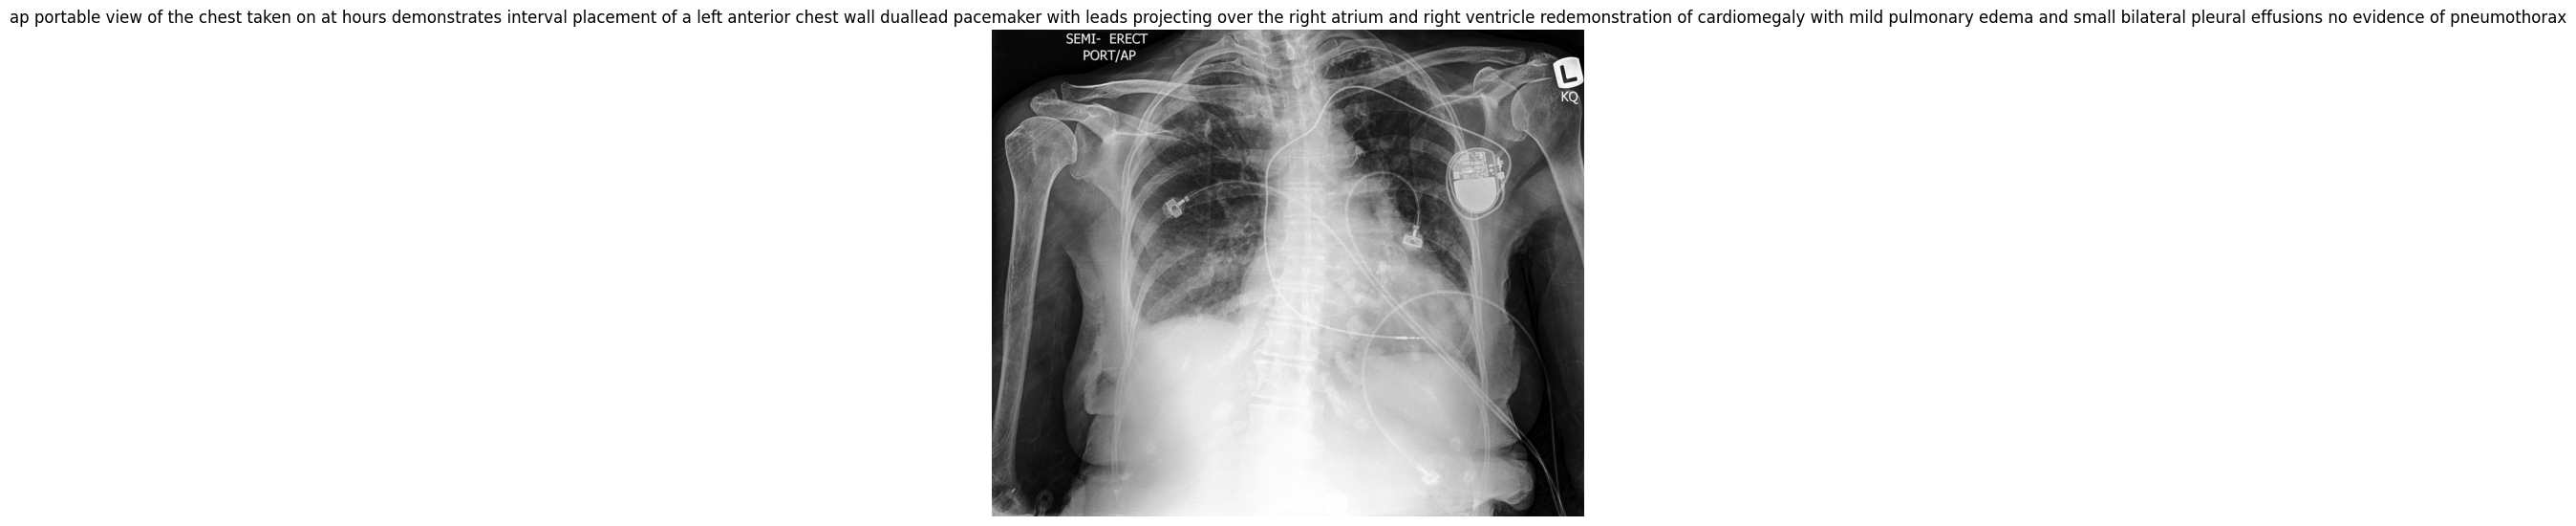

New best model saved with validation loss: 1.0206


Training Epoch 2:   0%|          | 1/221 [00:12<45:59, 12.54s/it]

Epoch [2/38], Step [0/221], Loss: 0.9355


Training Epoch 2:  46%|████▌     | 101/221 [21:29<30:46, 15.39s/it]

Epoch [2/38], Step [100/221], Loss: 0.9012


Training Epoch 2:  91%|█████████ | 201/221 [46:44<04:50, 14.53s/it]

Epoch [2/38], Step [200/221], Loss: 0.8986


Training Epoch 2: 100%|██████████| 221/221 [52:08<00:00, 14.16s/it]



Epoch 2 completed. Running validation...


100%|██████████| 63/63 [15:46<00:00, 15.02s/it]


Validation Loss: 1.0257
--------------------------------------------------


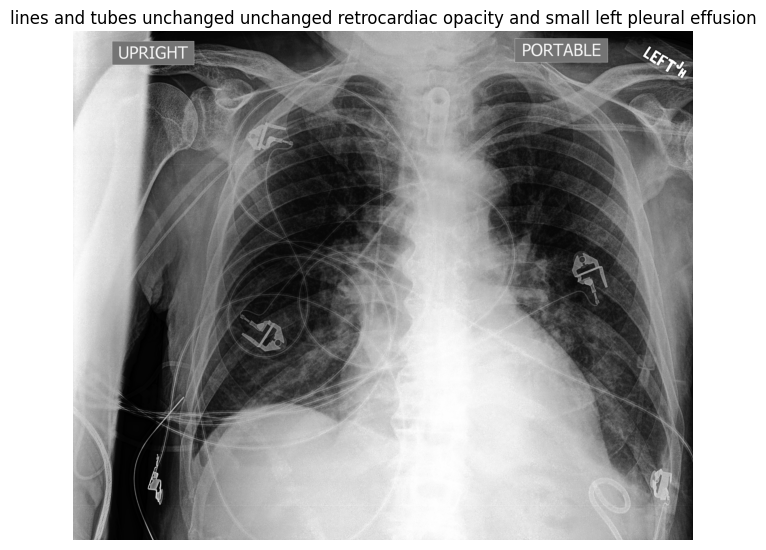

Training Epoch 3:   0%|          | 1/221 [00:11<41:46, 11.39s/it]

Epoch [3/38], Step [0/221], Loss: 0.8779


Training Epoch 3:  46%|████▌     | 101/221 [21:21<24:33, 12.28s/it]

Epoch [3/38], Step [100/221], Loss: 0.8867


Training Epoch 3:  91%|█████████ | 201/221 [46:37<05:26, 16.32s/it]

Epoch [3/38], Step [200/221], Loss: 0.9320


Training Epoch 3: 100%|██████████| 221/221 [52:03<00:00, 14.13s/it]



Epoch 3 completed. Running validation...


100%|██████████| 63/63 [16:07<00:00, 15.35s/it]


Validation Loss: 1.0258
--------------------------------------------------


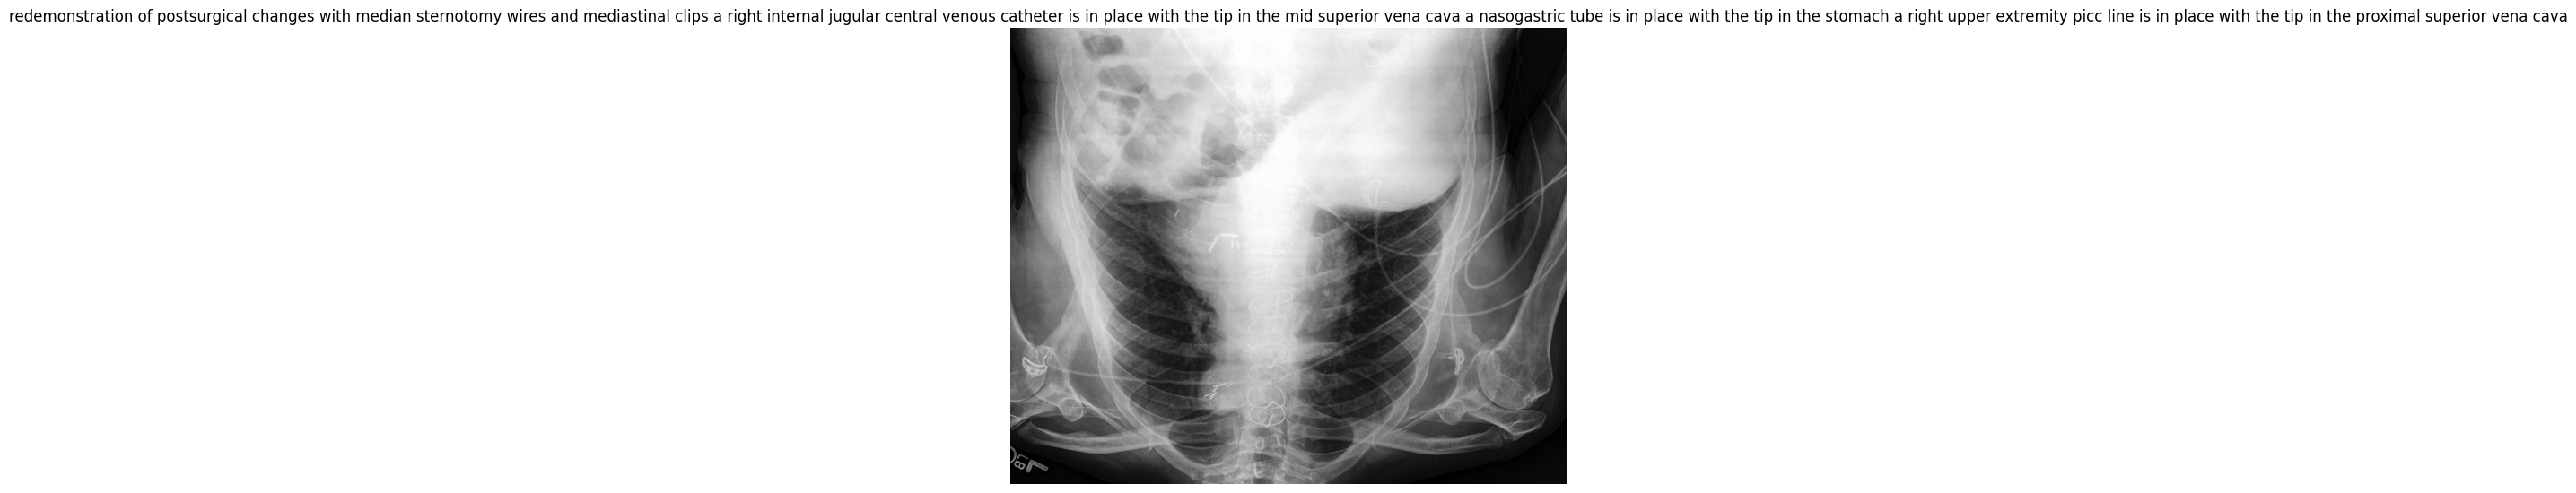

Training Epoch 4:   0%|          | 1/221 [00:12<46:02, 12.56s/it]

Epoch [4/38], Step [0/221], Loss: 0.9029


Training Epoch 4:  46%|████▌     | 101/221 [21:46<30:10, 15.08s/it]

Epoch [4/38], Step [100/221], Loss: 0.9582


Training Epoch 4:  91%|█████████ | 201/221 [47:42<05:49, 17.45s/it]

Epoch [4/38], Step [200/221], Loss: 0.8730


Training Epoch 4: 100%|██████████| 221/221 [52:45<00:00, 14.32s/it]



Epoch 4 completed. Running validation...


100%|██████████| 63/63 [16:21<00:00, 15.58s/it]


Validation Loss: 1.0364
--------------------------------------------------


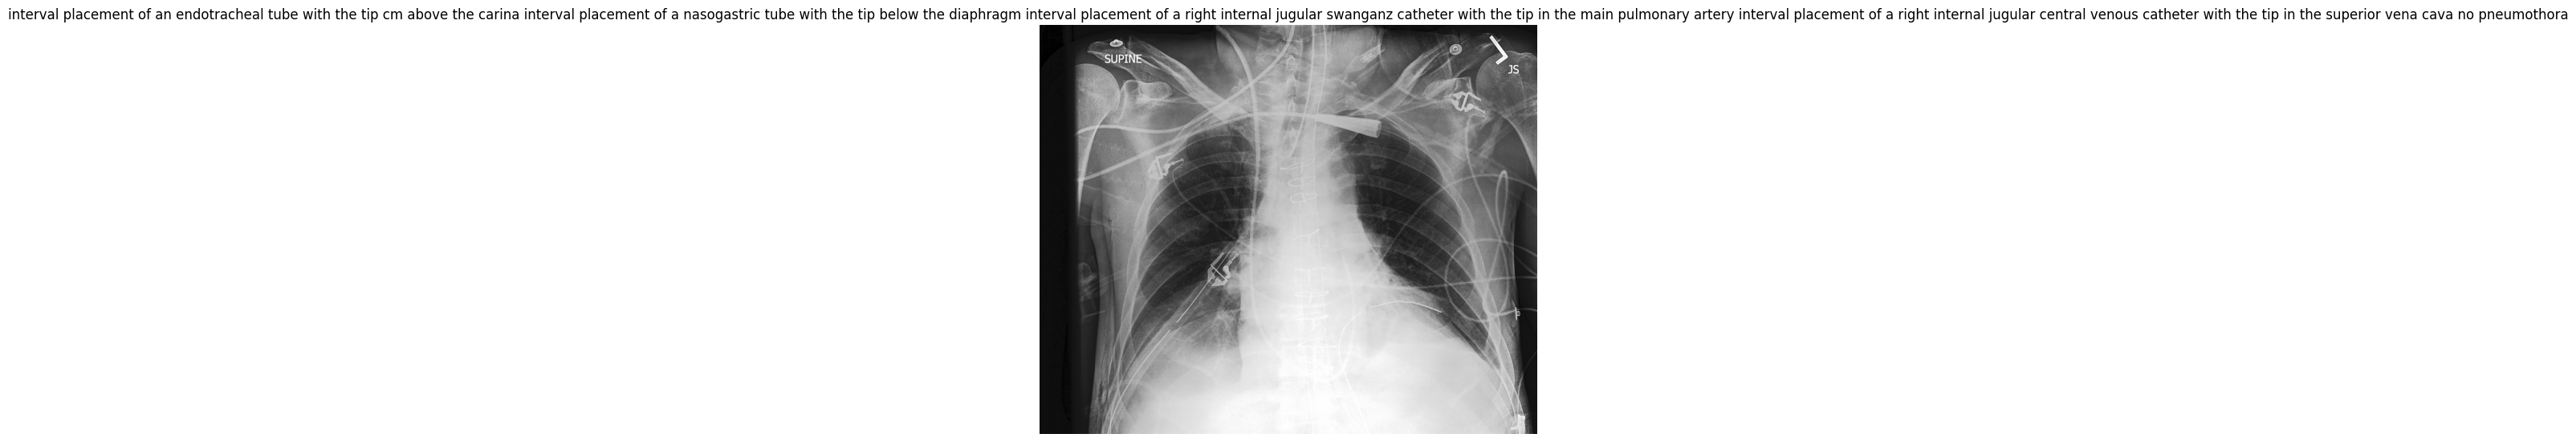

Training Epoch 5:   0%|          | 1/221 [00:15<57:08, 15.58s/it]

Epoch [5/38], Step [0/221], Loss: 0.8567


Training Epoch 5:  46%|████▌     | 101/221 [22:16<33:42, 16.86s/it]

Epoch [5/38], Step [100/221], Loss: 0.8937


Training Epoch 5:  91%|█████████ | 201/221 [49:58<04:52, 14.64s/it]

Epoch [5/38], Step [200/221], Loss: 0.8825


Training Epoch 5: 100%|██████████| 221/221 [55:36<00:00, 15.10s/it]



Epoch 5 completed. Running validation...


100%|██████████| 63/63 [16:30<00:00, 15.72s/it]


Validation Loss: 1.0501
--------------------------------------------------


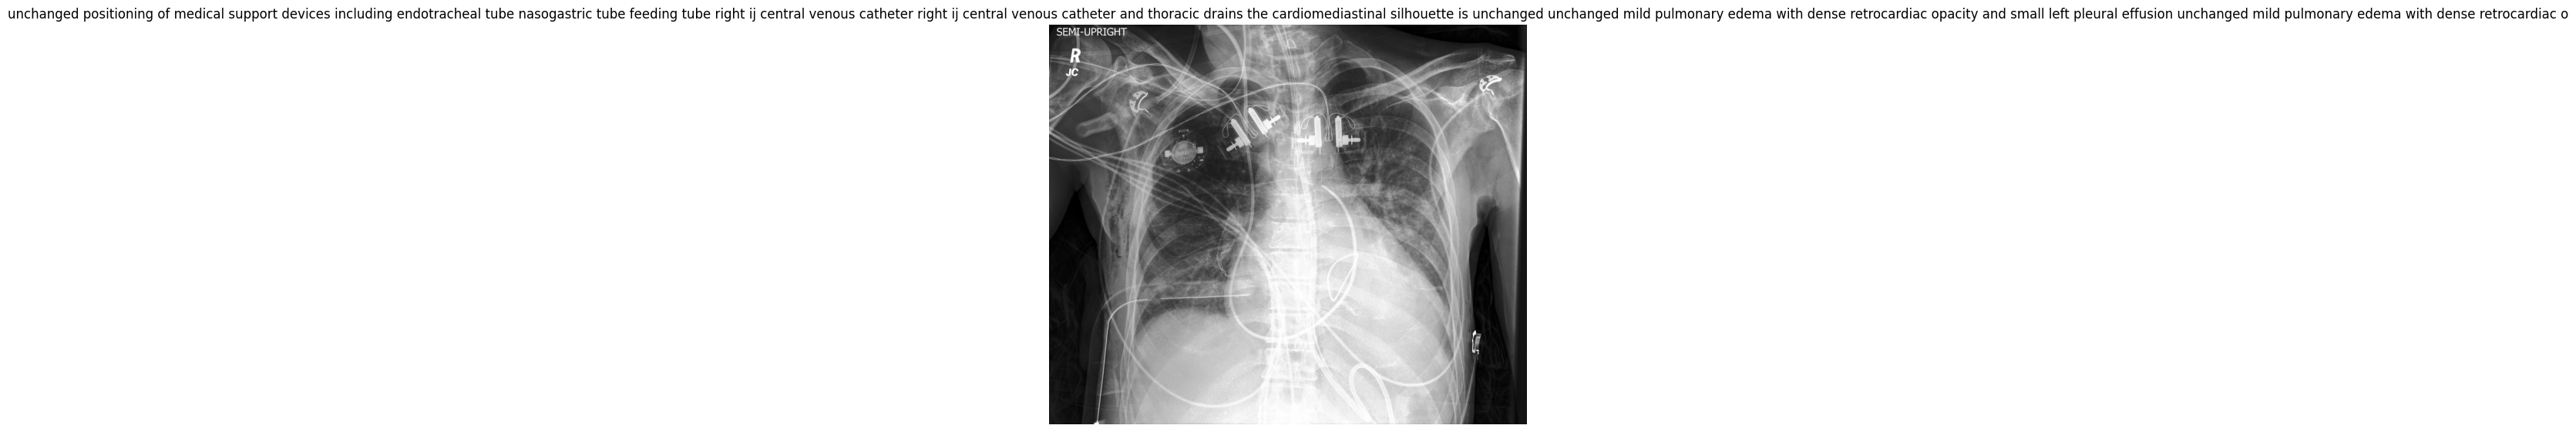

Training Epoch 6:   0%|          | 1/221 [00:17<1:02:37, 17.08s/it]

Epoch [6/38], Step [0/221], Loss: 0.8214


Training Epoch 6:  46%|████▌     | 101/221 [21:51<28:40, 14.34s/it]

Epoch [6/38], Step [100/221], Loss: 0.7987


Training Epoch 6:  91%|█████████ | 201/221 [47:32<05:52, 17.65s/it]

Epoch [6/38], Step [200/221], Loss: 0.8262


Training Epoch 6: 100%|██████████| 221/221 [52:53<00:00, 14.36s/it]



Epoch 6 completed. Running validation...


100%|██████████| 63/63 [16:07<00:00, 15.36s/it]


Validation Loss: 1.0631
--------------------------------------------------


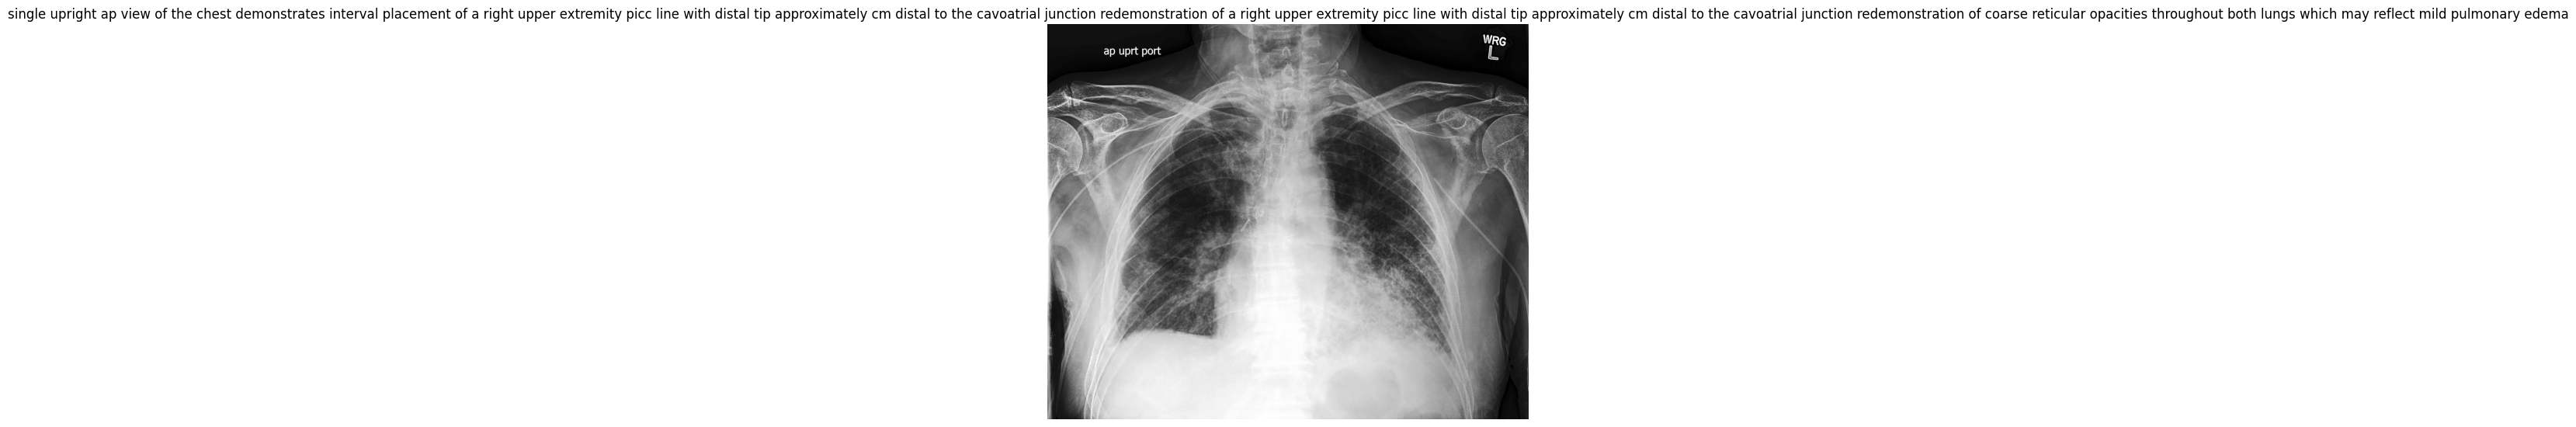

Training Epoch 7:   0%|          | 1/221 [00:11<41:20, 11.28s/it]

Epoch [7/38], Step [0/221], Loss: 0.8181


Training Epoch 7:  46%|████▌     | 101/221 [21:21<24:09, 12.08s/it]

Epoch [7/38], Step [100/221], Loss: 0.7529


Training Epoch 7:  91%|█████████ | 201/221 [47:42<04:49, 14.46s/it]

Epoch [7/38], Step [200/221], Loss: 0.7652


Training Epoch 7: 100%|██████████| 221/221 [52:27<00:00, 14.24s/it]



Epoch 7 completed. Running validation...


100%|██████████| 63/63 [12:00<00:00, 11.44s/it]


Validation Loss: 1.0768
--------------------------------------------------


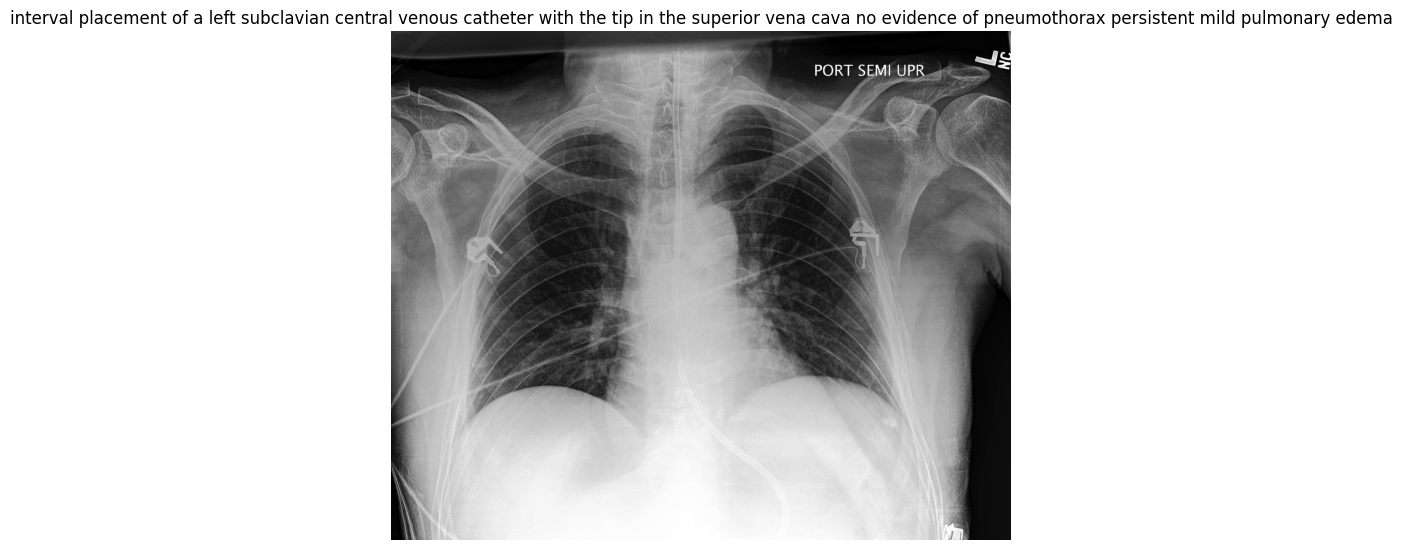

Training Epoch 8:   0%|          | 1/221 [00:11<42:38, 11.63s/it]

Epoch [8/38], Step [0/221], Loss: 0.7299


Training Epoch 8:  46%|████▌     | 101/221 [20:34<22:06, 11.05s/it]

Epoch [8/38], Step [100/221], Loss: 0.7596


Training Epoch 8:  91%|█████████ | 201/221 [43:07<04:53, 14.67s/it]

Epoch [8/38], Step [200/221], Loss: 0.8209


Training Epoch 8: 100%|██████████| 221/221 [48:09<00:00, 13.08s/it]



Epoch 8 completed. Running validation...


100%|██████████| 63/63 [11:37<00:00, 11.07s/it]


Validation Loss: 1.0870
--------------------------------------------------


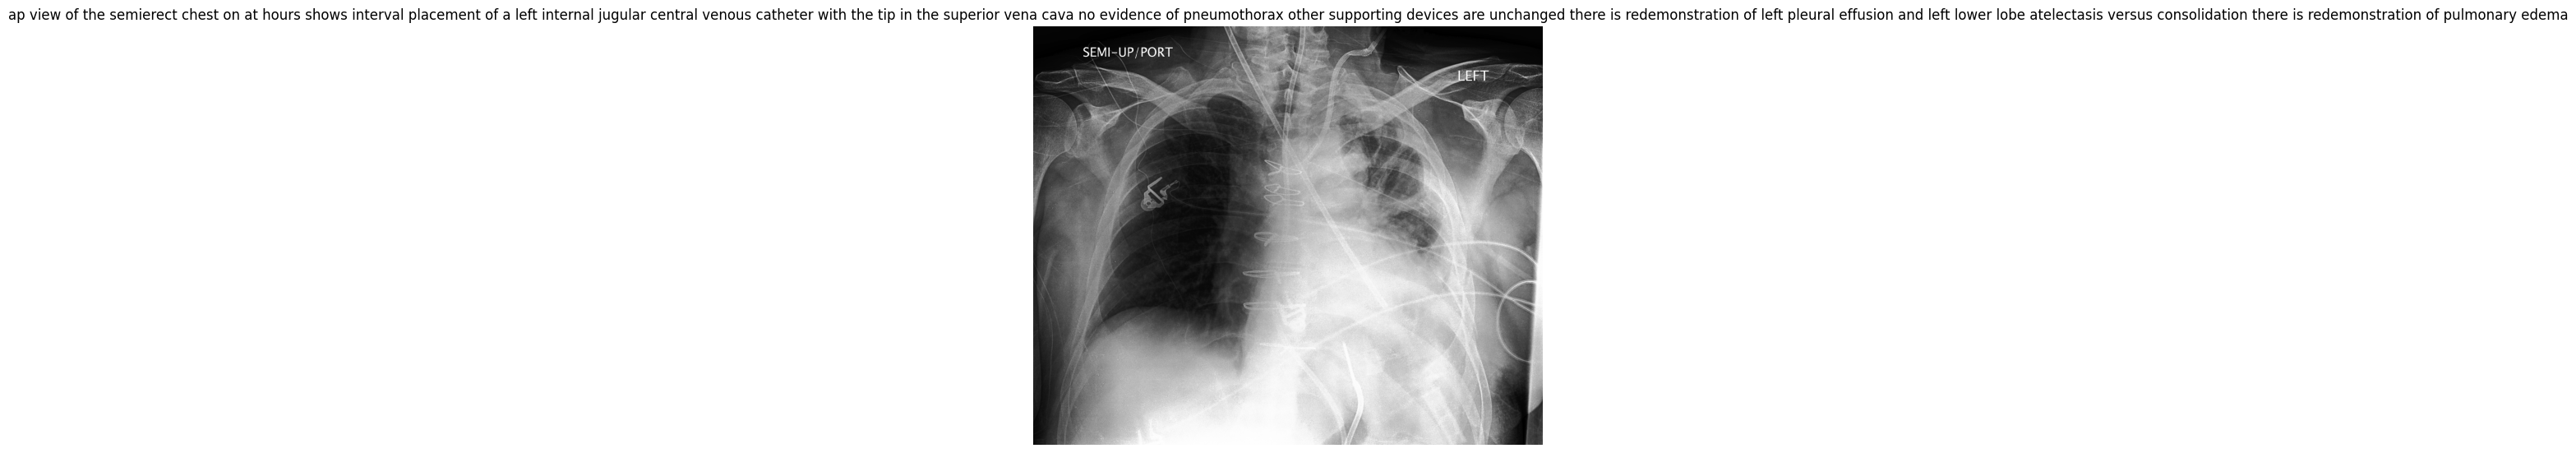

Training Epoch 9:   0%|          | 1/221 [00:11<42:50, 11.68s/it]

Epoch [9/38], Step [0/221], Loss: 0.7897


Training Epoch 9:  46%|████▌     | 101/221 [19:42<23:02, 11.52s/it]

Epoch [9/38], Step [100/221], Loss: 0.7417


Training Epoch 9:  91%|█████████ | 201/221 [39:17<03:49, 11.49s/it]

Epoch [9/38], Step [200/221], Loss: 0.8144


Training Epoch 9: 100%|██████████| 221/221 [42:59<00:00, 11.67s/it]



Epoch 9 completed. Running validation...


100%|██████████| 63/63 [10:53<00:00, 10.38s/it]


Validation Loss: 1.1120
--------------------------------------------------


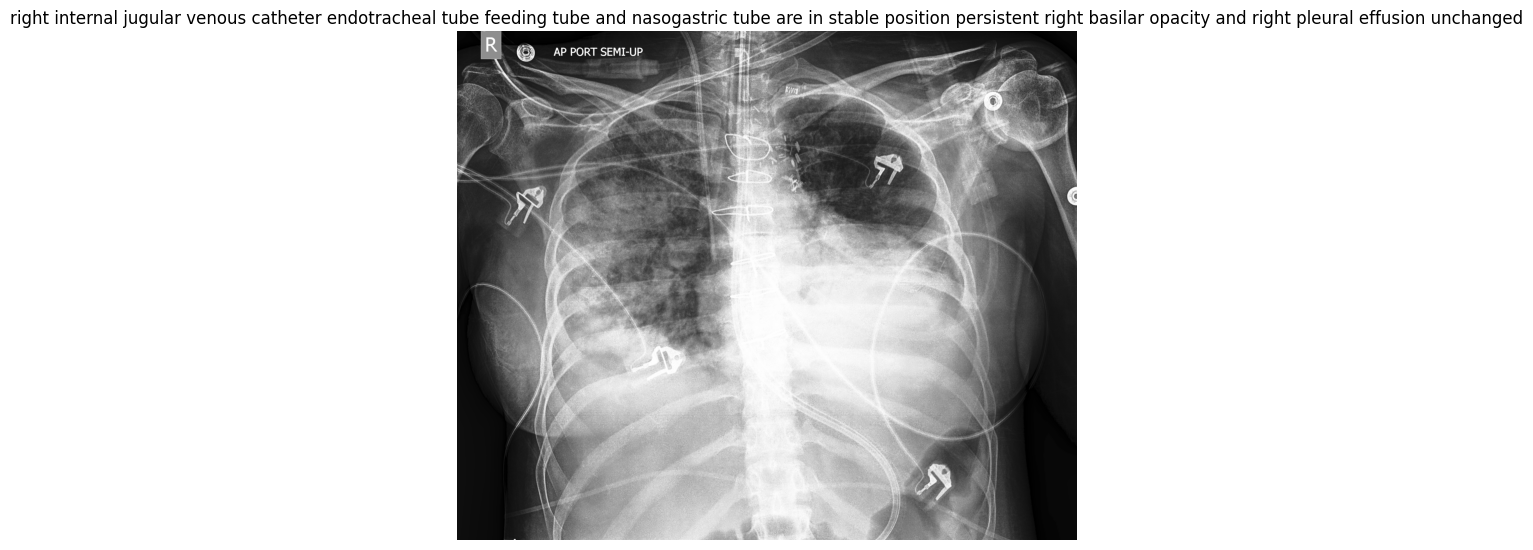

Training Epoch 10:   0%|          | 1/221 [00:10<40:03, 10.92s/it]

Epoch [10/38], Step [0/221], Loss: 0.7128


Training Epoch 10:  46%|████▌     | 101/221 [17:51<23:09, 11.58s/it]

Epoch [10/38], Step [100/221], Loss: 0.7577


Training Epoch 10:  91%|█████████ | 201/221 [37:02<04:03, 12.15s/it]

Epoch [10/38], Step [200/221], Loss: 0.7099


Training Epoch 10: 100%|██████████| 221/221 [41:03<00:00, 11.15s/it]



Epoch 10 completed. Running validation...


100%|██████████| 63/63 [11:30<00:00, 10.96s/it]


Validation Loss: 1.1266
--------------------------------------------------


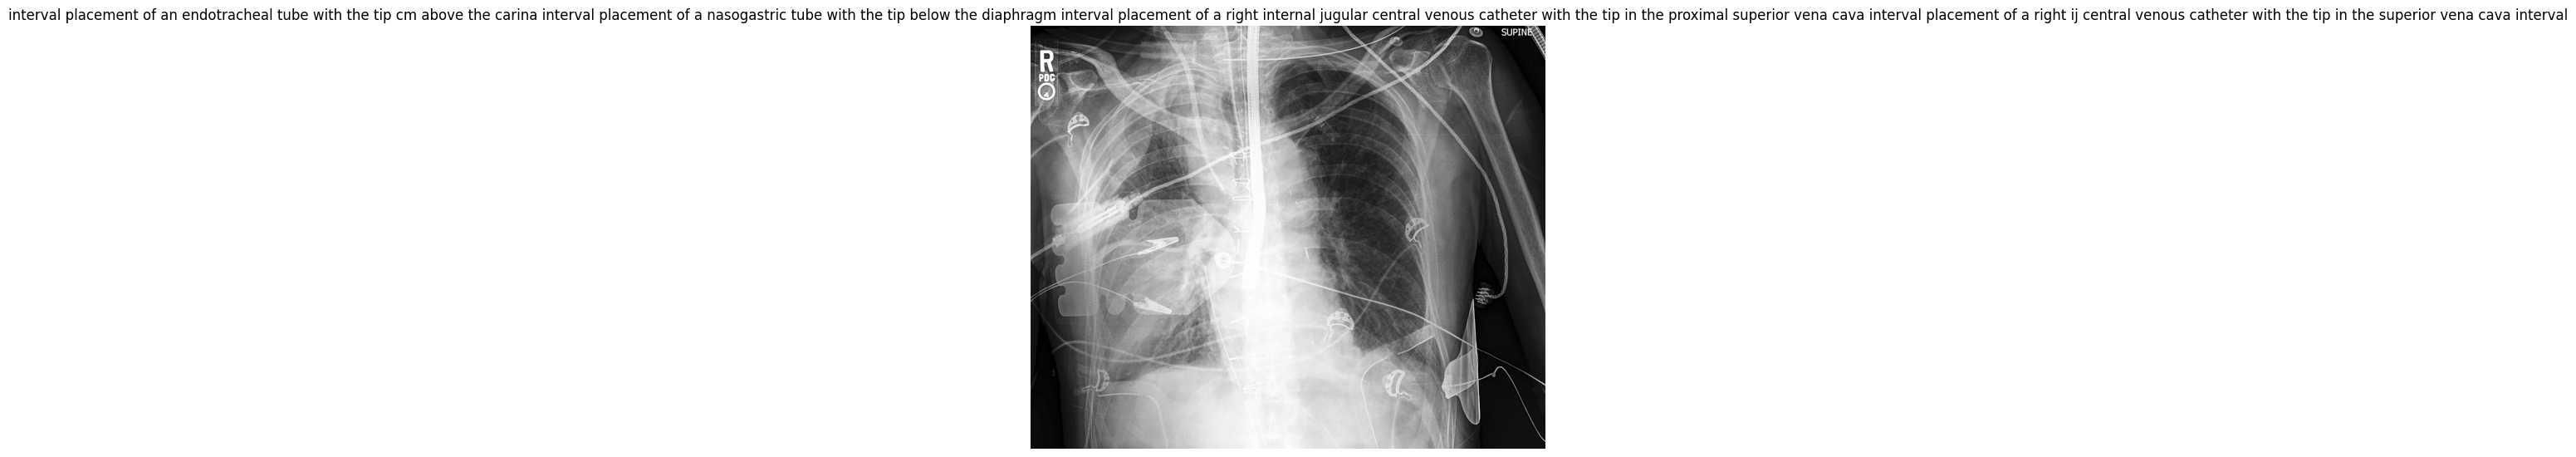

Training Epoch 11:   0%|          | 1/221 [00:10<37:46, 10.30s/it]

Epoch [11/38], Step [0/221], Loss: 0.6901


Training Epoch 11:  46%|████▌     | 101/221 [17:37<21:17, 10.65s/it]

Epoch [11/38], Step [100/221], Loss: 0.7898


Training Epoch 11:  91%|█████████ | 201/221 [37:12<04:08, 12.44s/it]

Epoch [11/38], Step [200/221], Loss: 0.7149


Training Epoch 11: 100%|██████████| 221/221 [41:25<00:00, 11.25s/it]



Epoch 11 completed. Running validation...


100%|██████████| 63/63 [12:01<00:00, 11.45s/it]


Validation Loss: 1.1548
--------------------------------------------------


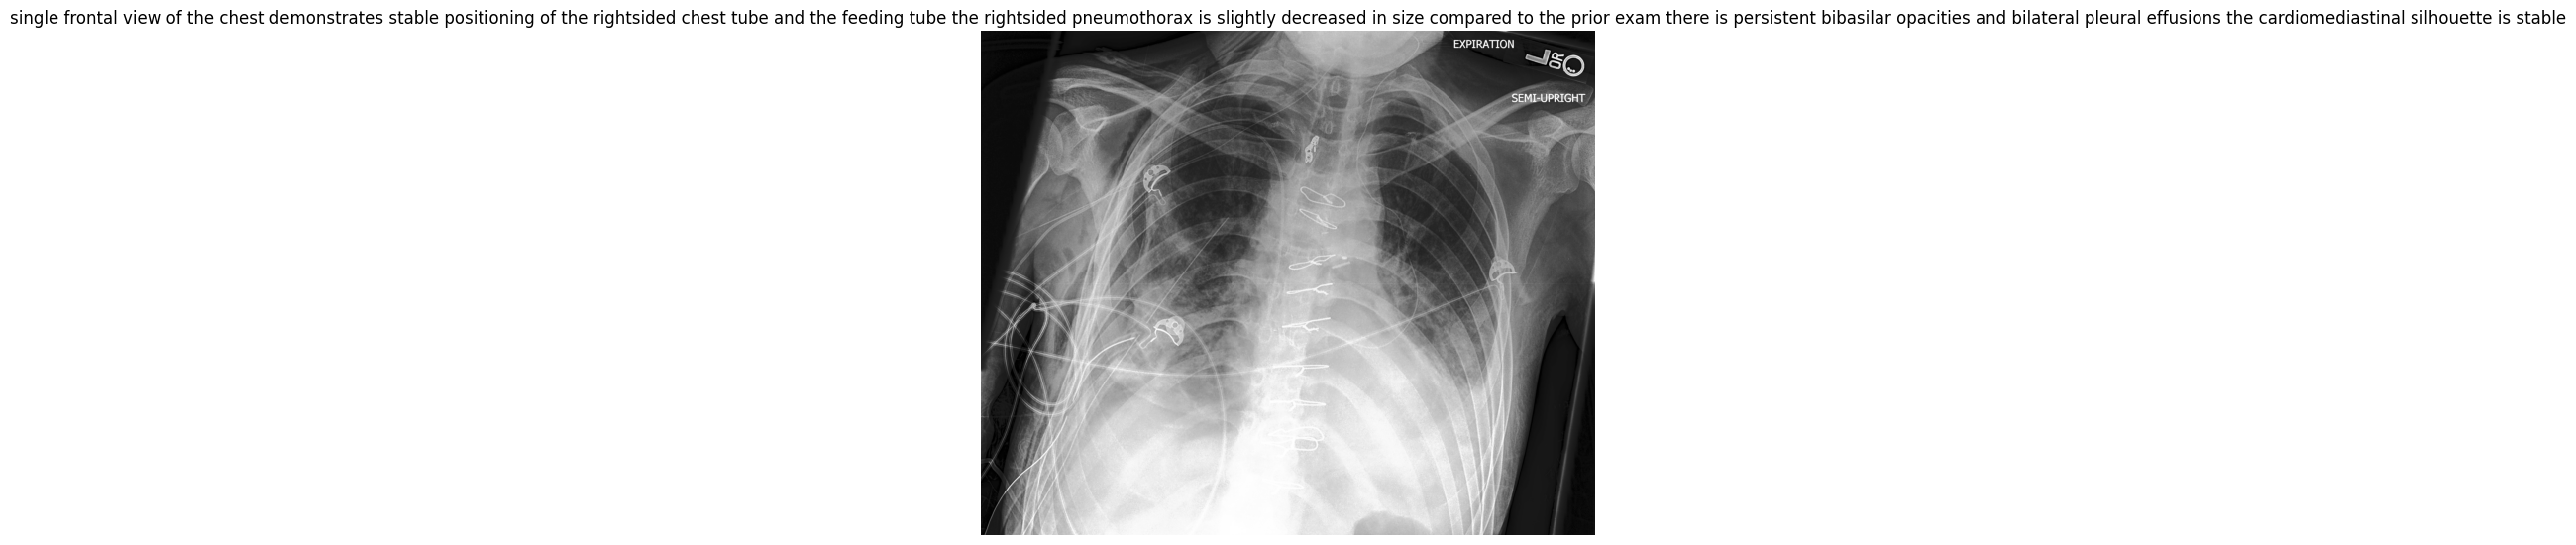

Training Epoch 12:   0%|          | 1/221 [00:09<36:22,  9.92s/it]

Epoch [12/38], Step [0/221], Loss: 0.6985


Training Epoch 12:  46%|████▌     | 101/221 [19:00<22:06, 11.05s/it]

Epoch [12/38], Step [100/221], Loss: 0.6671


Training Epoch 12:  91%|█████████ | 201/221 [42:22<06:04, 18.24s/it]

Epoch [12/38], Step [200/221], Loss: 0.6631


Training Epoch 12: 100%|██████████| 221/221 [47:34<00:00, 12.92s/it]



Epoch 12 completed. Running validation...


100%|██████████| 63/63 [14:38<00:00, 13.94s/it]


Validation Loss: 1.1655
--------------------------------------------------


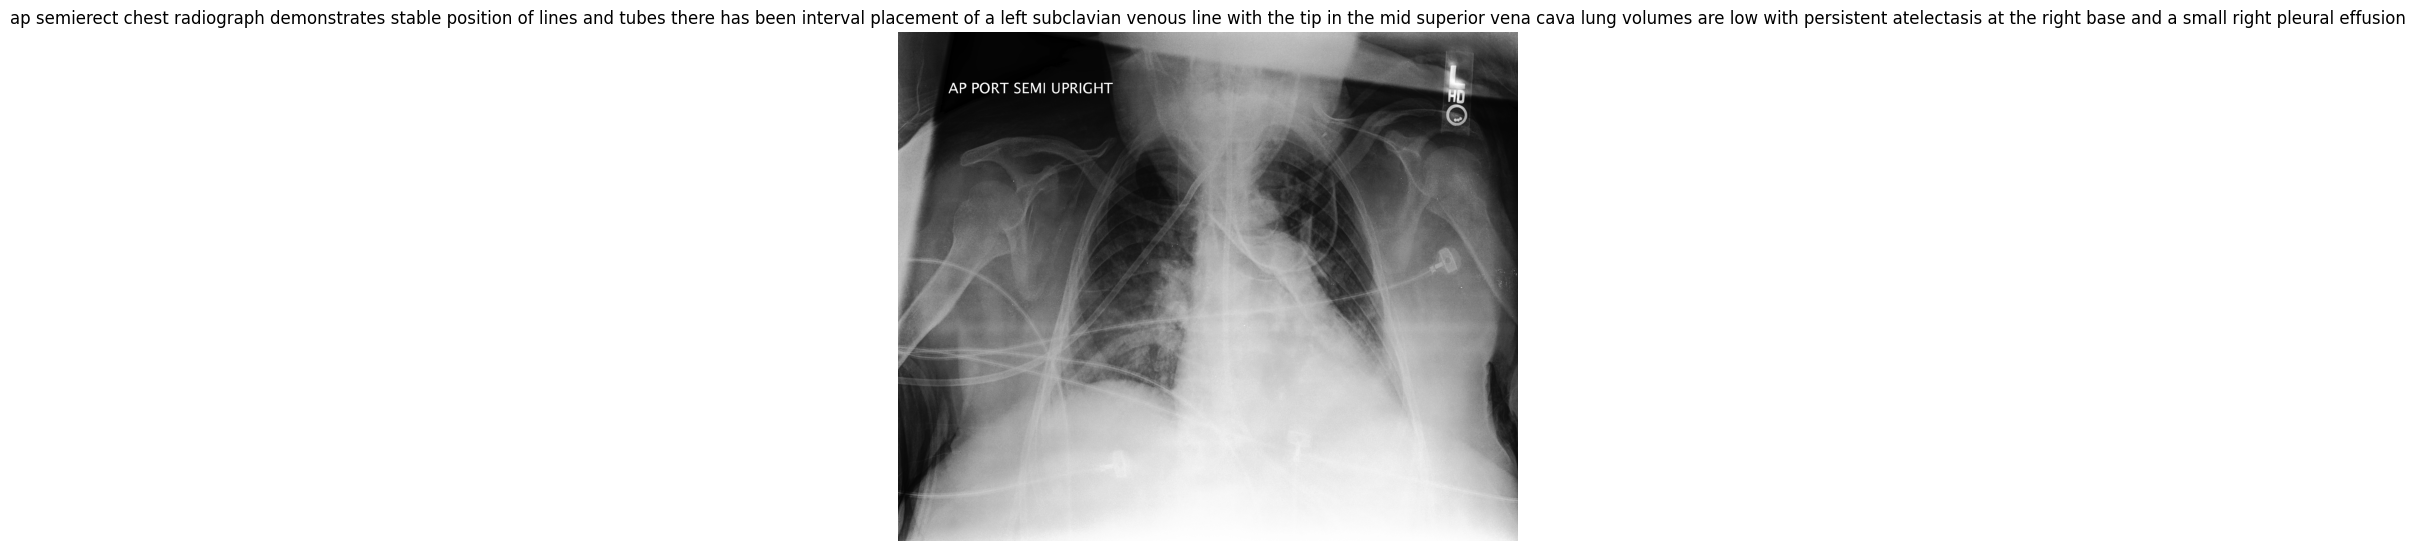

Training Epoch 13:   0%|          | 1/221 [00:13<49:13, 13.43s/it]

Epoch [13/38], Step [0/221], Loss: 0.6287


Training Epoch 13:  46%|████▌     | 101/221 [21:20<24:18, 12.15s/it]

Epoch [13/38], Step [100/221], Loss: 0.6263


Training Epoch 13:  91%|█████████ | 201/221 [45:02<04:47, 14.36s/it]

Epoch [13/38], Step [200/221], Loss: 0.6827


Training Epoch 13: 100%|██████████| 221/221 [49:56<00:00, 13.56s/it]



Epoch 13 completed. Running validation...


100%|██████████| 63/63 [14:50<00:00, 14.13s/it]


Validation Loss: 1.1931
--------------------------------------------------


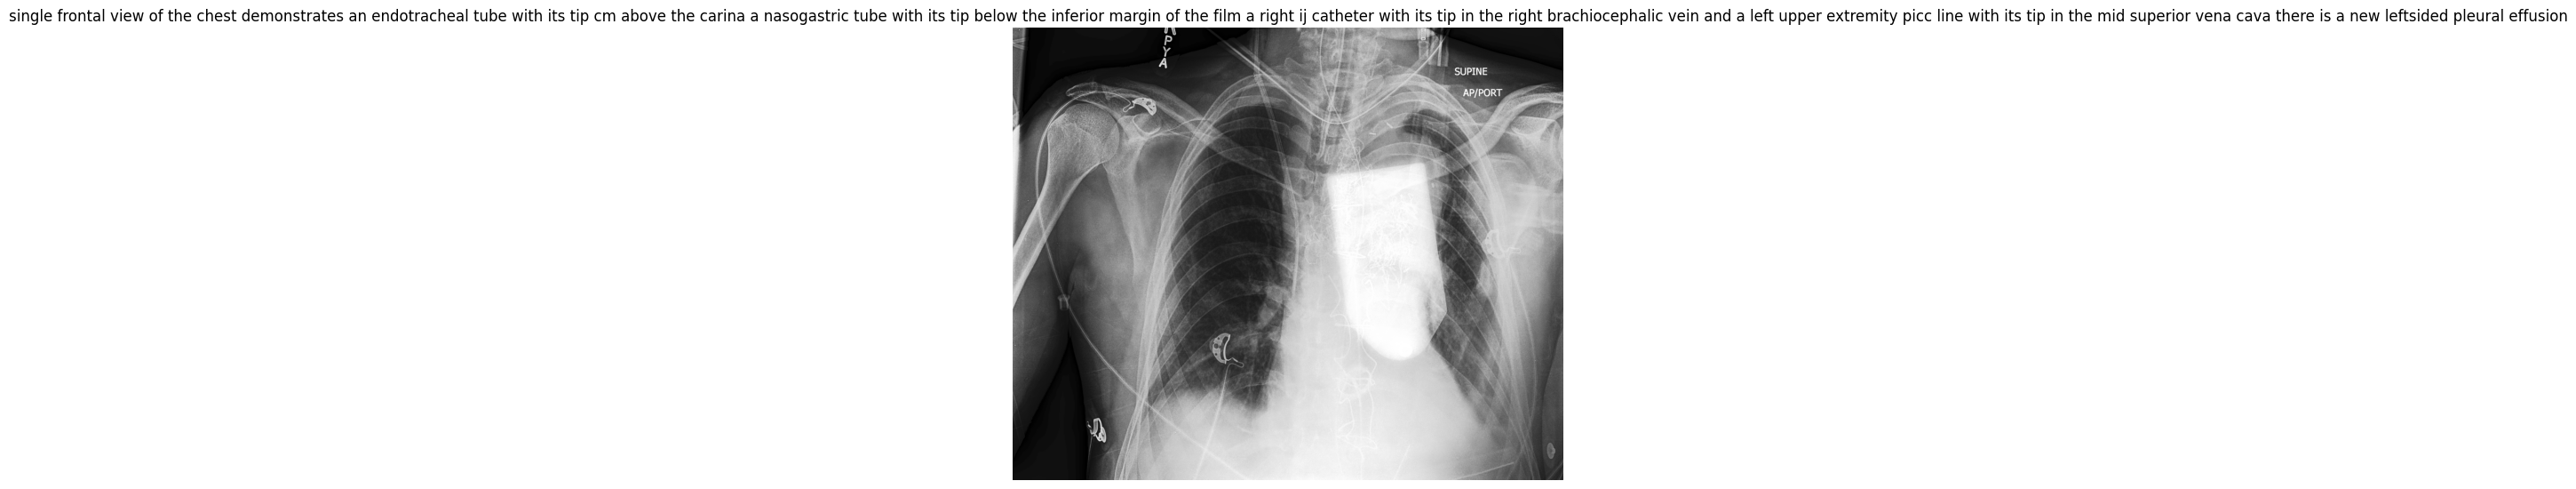

Training Epoch 14:   0%|          | 1/221 [00:17<1:05:48, 17.95s/it]

Epoch [14/38], Step [0/221], Loss: 0.6471


Training Epoch 14:  38%|███▊      | 85/221 [16:45<34:15, 15.12s/it] 

In [3]:
###############################################
# Main: Data Preparation and Model Training in Jupyter
###############################################

# Set paths and parameters manually for Jupyter Notebook.
train_jsonl_path = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/train.jsonl'  # Path to your training JSONL file
val_jsonl_path = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/val.jsonl'      # Path to your validation JSONL file
train_img_dir = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/train'          # Directory containing your image files
val_img_dir = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/val'              # Directory containing your image files

batch_size = 128
num_epochs = 38
max_length = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image preprocessing.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load T5 tokenizer.
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Create training and validation datasets.
train_dataset = ImageCaptionDataset(train_jsonl_path, train_img_dir, transform=transform)
val_dataset = ImageCaptionDataset(val_jsonl_path, val_img_dir, transform=transform)

# Create DataLoaders for training and validation.
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length=max_length)
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length=max_length)
)

# Initialize the image captioning model.
model = ImageCaptioningModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.load_state_dict(torch.load('swin-t5-model.pth', map_location=device))
# Start training with validation after each epoch.
train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs)

In [3]:
max_length = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image preprocessing.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load T5 tokenizer.
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Initialize the image captioning model.
model = ImageCaptioningModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(torch.load('swin-t5-model.pth', map_location=device))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


<All keys matched successfully>

In [4]:
val_img_dir = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/val'
num_imgs = 5

for i in range(num_imgs):
    generate_caption_for_random_image(model, val_img_dir, transform, tokenizer, device, max_length=max_length)

KeyboardInterrupt: 

In [5]:
import evaluate
from tqdm import tqdm
from transformers.modeling_outputs import BaseModelOutput

def compute_evaluation_metrics(model, test_dataset, tokenizer, device, max_length=50):
    """
    Generates captions for the test dataset and computes BLEU, ROUGE, and METEOR scores.

    Args:
        model: Your trained ImageCaptioningModel (using T5 in this case).
        test_dataset: An instance of ImageCaptionDataset for the test set.
        tokenizer: The T5Tokenizer used for decoding.
        device: torch.device to run inference on.
        max_length: Maximum length for generated captions.

    Returns:
        A dictionary with BLEU, ROUGE, and METEOR scores.
    """
    model.eval()
    references = []   # Each ground truth caption is wrapped in a list.
    hypotheses = []   # List of generated captions

    for i in tqdm(range(len(test_dataset)), desc="Evaluating test set"):
        image, gt_caption = test_dataset[i]
        # Add batch dimension and move to device.
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Extract image features using the Swin encoder.
            swin_outputs = model.swin(image)
            img_feats = swin_outputs.last_hidden_state
            # Project features to match T5's hidden dimension.
            img_feats_proj = model.img_proj(img_feats)
            # Wrap projected features as encoder outputs.
            encoder_outputs = BaseModelOutput(last_hidden_state=img_feats_proj)
            # Generate caption using T5's generate method.
            generated_ids = model.t5.generate(
                encoder_outputs=encoder_outputs,
                max_length=max_length,
                num_beams=4,
                early_stopping=True
            )
            generated_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        
        hypotheses.append(generated_caption)
        references.append([gt_caption])  # Wrap the reference in a list for compatibility.

    # Load metrics from the evaluate library.
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    meteor_metric = evaluate.load("meteor")

    # Compute the metrics.
    bleu_score = bleu_metric.compute(predictions=hypotheses, references=references)
    rouge_score = rouge_metric.compute(predictions=hypotheses, references=references)
    meteor_score = meteor_metric.compute(predictions=hypotheses, references=references)

    print("BLEU:", bleu_score)
    print("ROUGE:", rouge_score)
    print("METEOR:", meteor_score)

    return {"BLEU": bleu_score, "ROUGE": rouge_score, "METEOR": meteor_score}

In [6]:
# Example usage:
test_jsonl_path = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/test.jsonl'
test_img_dir = '/cluster/home/ammaa/Downloads/Projects/CheXpert-Report-Generation/dataset_splits/test'

# Create the test dataset.
test_dataset = ImageCaptionDataset(test_jsonl_path, test_img_dir, transform=transform)

# Evaluate on the test set.
metrics = compute_evaluation_metrics(model, test_dataset, tokenizer, device, max_length=100)

Evaluating test set: 100%|██████████| 4026/4026 [1:14:48<00:00,  1.11s/it]
[nltk_data] Downloading package wordnet to
[nltk_data]     /cluster/home/ammaa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /cluster/home/ammaa/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /cluster/home/ammaa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU: {'bleu': 0.06867550212919903, 'precisions': [0.3320443588913684, 0.1181580981270666, 0.05359491125034958, 0.027226560833013273], 'brevity_penalty': 0.7895104056666021, 'length_ratio': 0.8088375105060832, 'translation_length': 176109, 'reference_length': 217731}
ROUGE: {'rouge1': 0.3005787645448652, 'rouge2': 0.10751084186646034, 'rougeL': 0.2225727497381421, 'rougeLsum': 0.22256368169528368}
METEOR: {'meteor': 0.23387004460915078}
